# Import Libraries

In [1]:
import os
import cv2
import numpy as np
import uuid
import matplotlib.pyplot as plt
from config import CWD, DATA_PATH, ANC_PATH, POS_PATH, NEG_PATH

# Import tensorflow dependencies - Functional API
from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

# Data Preprocessing

### Data augmentation

In [2]:
def data_aug(img):
    data = []
    for i in range(9):
        img = tf.image.stateless_random_brightness(img, max_delta=0.02, seed=(1,2))
        img = tf.image.stateless_random_contrast(img, lower=0.6, upper=1, seed=(1,3))
        img = tf.image.stateless_random_flip_left_right(img, seed=(np.random.randint(100),np.random.randint(100)))
        img = tf.image.stateless_random_jpeg_quality(img, min_jpeg_quality=90, max_jpeg_quality=100, seed=(np.random.randint(100),np.random.randint(100)))
        img = tf.image.stateless_random_saturation(img, lower=0.9,upper=1, seed=(np.random.randint(100),np.random.randint(100)))

        data.append(img)
    
    return data

In [3]:
for file_name in os.listdir(os.path.join(POS_PATH)):
    img_path = os.path.join(POS_PATH, file_name)
    img = cv2.imread(img_path)
    augmented_images = data_aug(img) 
    
    for image in augmented_images:
        cv2.imwrite(os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1())), image.numpy())

In [5]:
for file_name in os.listdir(os.path.join(ANC_PATH)):
    img_path = os.path.join(ANC_PATH, file_name)
    img = cv2.imread(img_path)
    augmented_images = data_aug(img) 
    
    for image in augmented_images:
        cv2.imwrite(os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1())), image.numpy())

In [6]:
# Get Image Directories
anchor_paths = tf.data.Dataset.list_files(ANC_PATH+'\*.jpg').take(3000)
positive_paths = tf.data.Dataset.list_files(POS_PATH+'\*.jpg').take(3000)
negative_paths = tf.data.Dataset.list_files(NEG_PATH+'\*.jpg').take(3000)

In [ ]:
dir_test = anchor_paths.as_numpy_iterator()
print(dir_test.next())

In [9]:
# Create Labelled Dataset
positives = tf.data.Dataset.zip((anchor_paths, positive_paths, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor_paths)))))
negatives = tf.data.Dataset.zip((anchor_paths, negative_paths, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor_paths)))))
data = positives.concatenate(negatives)

In [10]:
samples = data.as_numpy_iterator()
example = samples.next()
example

(b'D:\\face_verification\\data\\anchor\\f45baea0-ea6b-11ec-8632-bc542fd709a0.jpg',
 b'D:\\face_verification\\data\\positive\\0123b082-ea75-11ec-b412-bc542fd709a0.jpg',
 1.0)

### Scale and Resize

In [12]:
def preprocess(file_path):
    
    # Read in image from file path
    byte_img = tf.io.read_file(file_path)
    # Load in the image 
    img = tf.io.decode_jpeg(byte_img)
    
    # Preprocessing steps - resizing the image to be 224*224*3
    img = tf.image.resize(img, (224,224))
    # Scale image to be between 0 and 1 
    img = img / 255.0

    # Return image
    return img

In [13]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [14]:
res = preprocess_twin(*example)

In [ ]:
plt.imshow(res[1])

In [16]:
res[2]

1.0

# Build dataloader pipeline

In [19]:
# Build dataloader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=10000)

In [20]:
# Training partition
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [21]:
# Testing partition
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

# Modeling

## Image encodings

In [3]:
def image_encodings():
    
    model = VGG16(include_top=True, weights='imagenet')
    model = Model(inputs = model.inputs, outputs = model.layers[-2].output)
            
    return model

In [4]:
encoding = image_encodings()
encoding.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

## L1 Layer

In [5]:
# Siamese L1 Distance class
class L1Dist(Layer):
    
    # Init method - inheritance
    def __init__(self, **kwargs):
        super().__init__()
       
    # Magic happens here - similarity calculation
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

## Siamese Model

In [6]:
def make_siamese_model(): 
    
    # Anchor image input in the network
    input_image = Input(name='input_img', shape=(224,224,3))
    
    # Validation image in the network 
    validation_image = Input(name='validation_img', shape=(224,224,3))
    
    # Combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(encoding(input_image), encoding(validation_image))
    
    dense = Dense(512, activation='relu')(distances)
    
    # Classification layer 
    classifier = Dense(1, activation='sigmoid')(dense)
    
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [7]:
siamese_model = make_siamese_model()
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 model (Functional)             (None, 4096)         134260544   ['input_img[0][0]',              
                                                                  'validation_img[0][

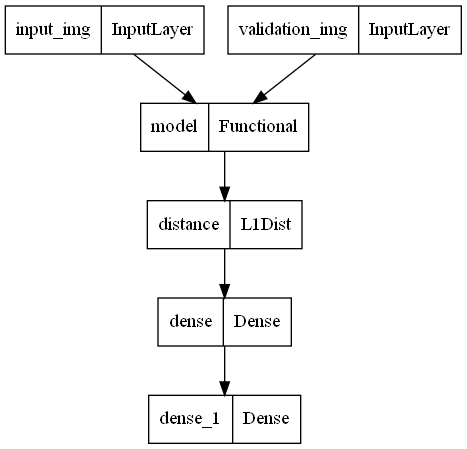

In [8]:
tf.keras.utils.plot_model(
    siamese_model,
    to_file='model.png',
    show_shapes=False,
    show_dtype=False,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=False,
    dpi=96,
    layer_range=None,
    show_layer_activations=False
)

In [38]:
binary_cross_loss = tf.losses.BinaryCrossentropy()
opt = tf.keras.optimizers.Adam(1e-4) # 0.0001

In [41]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

# Training

In [42]:
@tf.function
def train_step(batch):
    
    # Record all of our operations 
    with tf.GradientTape() as tape:     
        # Get anchor and positive/negative image
        X = batch[:2]
        # Get label
        y = batch[2]
        
        # Forward pass
        yhat = siamese_model(X, training=True)
        # Calculate loss
        loss = binary_cross_loss(y, yhat)
    print(loss)
        
    # Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    
    # Calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
        
    # Return loss
    return loss

In [43]:
# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall
def train(data, EPOCHS):
    # Loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        
        # Creating a metric object 
        r = Recall()
        p = Precision()
        
        # Loop through each batch
        for idx, batch in enumerate(data):
            # Run train step here
            loss = train_step(batch)
            yhat = siamese_model.predict(batch[:2])
            r.update_state(batch[2], yhat)
            p.update_state(batch[2], yhat) 
            progbar.update(idx+1)
        print(loss.numpy(), r.result().numpy(), p.result().numpy())
        
        # Save checkpoints
        if epoch % 10 == 0: 
            checkpoint.save(file_prefix=checkpoint_prefix)

In [ ]:
EPOCHS = 50
train(train_data, EPOCHS)

In [45]:
# Save weights
siamese_model.save('siamesemodelv2.h5')

# References:
1. DeepFace: Closing the Gap to Human-Level Performance in Face Verification
2. Nicholas Renotte, https://lnkd.in/gi7fYrUY